# Problem set 3: Optimization and Root Finding: The Consumer Problem

We will take a look at solving the canonical utility maximization problem for the consumer.  

**Problem set structure:** 
* Each problem set consists of tasks and problems. _Tasks_ train you in using specific techniques, while _problems_ train you in solving actual economic problems. 
* Each problem set also contains solutions, which can be found in separate Python files.
* The Python files `A[..].py` do not run out of the box. But you can copy the code into your notebook or user module. 
* *You should really try to solve the tasks and problems on your own before looking at the answers!* 
* You goal should, however, not be to write everything from scratch. 
* Finding similar code from the lectures and adjusting it is completely ok. I rarely begin  completely from scratch, I figure out when I last did something similar and copy in the code to begin with. A quick peak at the solution, and then trying to write the solution yourself is also a very beneficial approach.

**Multiple solutions:** Within the field of numerical analysis there is often many more than one way of solving a specific problem. So the solution provided is just one example. If you get the same result, but use another approach, that might be just as good (or even better).

In [21]:
import warnings
warnings.filterwarnings("ignore")

**Table of contents**<a id='toc0_'></a>    
- [1. Functions](#toc1_)    
- [2. Function continued](#toc2_)    
- [3. Methods to solve and optimize](#toc3_)    
  - [3.1 Brute‑Force Grid Search](#toc3_1_)    
  - [3.2 Bisection](#toc3_2_)    
  - [3.3 Newton's Method](#toc3_3_)    
  - [3.4 scipy.optimize](#toc3_4_)    
- [4. Other Optimizers - Comparing Methods (more difficult)](#toc4_)    
- [5. Sensitivity: Price shock](#toc5_)    
- [6. Sensitivity: Starting Values & Solver Choices](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[1. Functions](#toc0_)

Implement a Python version of this function:

$$ 
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta} 
$$

In [22]:
# set autoreload so that changes in A*.py files are reflected without restarting the notebook
# just a technicality, and not used in my (Casper) notebooks / solution - because i dont change modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# write your own code here
def u(x_1,x_2,alpha=0.5,beta=0.5):
    if x_1 > 0 and x_2 > 0:
        u = (alpha*x_1**(-beta) + (1-alpha)*x_2**(-beta))**(-1/beta)
        return u

# You do not need to assign the calculated value (or valueS if you input arrays)
# This is the exact same thing:
def u(x1,x2,alpha=0.5,beta=0.5):
    if x1 > 0 and x2 > 0:
        return (alpha*x1**(-beta)+(1-alpha)*x2**(-beta))**(-1/beta)

# Note that i defined two functions with the same name!
# Just like with variables python will overwrite the u function such that the last definitions holds

In [24]:
# example of overwriting functions:
def my_function(a:int): # :int tells python to only return values involving the variable a
    return 2*a          # if a is in fact an integer.
                        # you could implement the same with if type(a) == 'int': return 2*a

# Use the function to do calculations
val1 = my_function(2)
print(val1)

# create a new function with the exact same name "my_function"
def my_function(a:int, user_name:str): # the inclusion of user_name is just to demonstrate that the
                                       # new function with the same name can take completely new inputs / arguments
    print(f'Function activated by: {user_name}')
    return -2*a

val2 = my_function(2, 'MO-tothe-ES')
print(val2)

4
Function activated by: MO-tothe-ES
-4


## <a id='toc2_'></a>[2. Function continued](#toc0_)

Solve the above consumer problem with the CES utility function.

$$
u(x_1,x_2) = (\alpha x_1^{-\beta} + (1-\alpha) x_2^{-\beta})^{-1/\beta}
$$

Subject to the Budget Constraint:
$$ p_1 x_1 + p_2 x_2 \le I, \quad x_1 \ge 0,\; x_2 \ge 0. $$

Tasks: Use your function from above that contains the CES utility function and embed it into another function *value_of_choice_ces* that returns the value of utility *u*.

In [25]:
import numpy as np

# Use these baseline parameters
alpha = 0.5
beta = 0.000001
I = 10
p1 = 1
p2 = 2


In [26]:
## write the functions here
# We want to incoorperate the budget constraint (a mathematical restriction on the input values)
# The function is monotone! ie. the partial derivatives are always non zero (in this case even strictly non zero)

# Therefore rewrite the budget constraint in terms of x_1 (or x_2 if you want!)
# p_1*x_1 + p_2*x_2 = I \iff x_2 = I/p_2 - p_1/p_2 * x_1
# and use this to calculate the implicit x_2 value given any x_1 value:
def x2_implicit(x1, I=I, p1=p1, p2=p2):
    return (I-p1*x1)/p2

# Lets try it out!
val = x2_implicit(5,I=10,p1=1,p2=1)
print(f'x2 calucated from x1, income and prices: {val}\n') # \n mean "newline" and works in almost all programming languages
                                                           # its just like pressing enter.

def value_of_choice_ces(x1, alpha=0.5, beta=0.5, p1=1, p2=1, I=10):
    x2 = x2_implicit(x1,I,p1,p2)
    util = u(x1,x2,alpha,beta)
    return util

# use the function for some values
val = value_of_choice_ces(5, alpha=alpha, beta=beta, p1=p1, p2=p2, I=I)
print(f'CES Utility with budget constraint: {val}')

x2 calucated from x1, income and prices: 5.0

CES Utility with budget constraint: 3.535533693620822


Next, we will compare different methods to solve the consumer problem.

## <a id='toc3_'></a>[3. Methods to solve and optimize](#toc0_)

### <a id='toc3_1_'></a>[3.1 Brute‑Force Grid Search](#toc0_)
Set up a grid of the budget set and solve the consumer problem on the grid.

**Idea:** Search over a grid for  $c_1 \in [0, I/p_1]$, and  $c_2 \in [0, I/p_2]$ to find the values of $c_1$ and $c_2$ that maximize utility.


In [27]:
# As always: if you have not installed the required packages run the following line in your terminal
# pip install types
from types import SimpleNamespace

# Remember grid_solve is a custom module, so it should be in the same folder as this notebook!
# I stored it in a folder called custom_modules, hence the prefix "custom_modules.".
from custom_modules.grid_solve import print_solution

In [28]:
# What is SimpleNamespace()??
# Basically just a quick way of doing this (you do not need to understand this!)
class Cmo_SimpleNamespace:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            self.__dict__[key] = value

# Trying out my own SimpleNamespace class
instance_of_cmoClass = Cmo_SimpleNamespace(x1=6, x2=10, bob='nine')
print(instance_of_cmoClass.x1,
      instance_of_cmoClass.x2,
      instance_of_cmoClass.bob)

# Examples of using SimpleNamespace 
# (the exact same functionality as above but using the built-in SimpleNamespace class)
instance_of_SimpleNamespace = SimpleNamespace(x1=4, x2='twæn', bob=10)
print(instance_of_SimpleNamespace.x1,
      instance_of_SimpleNamespace.x2,
      instance_of_SimpleNamespace.bob)


6 10 nine
4 twæn 10


**Task**: Modify the grid search function below to add the additional parameter for the CES utility function $\beta$ and print the results. Note that you also need to use of the utility function. Make sure it runs below.

In [29]:
# We have to update (or overwrite) out utility function to handles zero consumption
def u(x1,x2,alpha=0.5,beta=0.5):
    if (x1 <= 0) or (x2 <= 0):
        return -np.inf  # This evaluates to be smaller than any real number 
                        # (you could also just return None or 0,
                        # but that would cause problems in comparisons with other values)
    return (alpha*x1**(-beta) + (1-alpha)*x2**(-beta))**(-1/beta)

In [30]:
def find_best_choice(u_func,alpha,beta,I,p1,p2,N1,N2,do_print=True):
    
    # a. allocate numpy arrays
    shape_tuple = (N1,N2)
    x1_values = np.empty(shape_tuple)
    x2_values = np.empty(shape_tuple)
    u_values = np.empty(shape_tuple)
    
    # b. start from guess of x1=x2=0 (whenever we find a combination that is better we update these values)
    x1_best = 0
    x2_best = 0
    u_best = u_func(0,0,alpha=alpha,beta=beta)
    
    # c. loop through all possibilities (to evaluate the function values for all points on our grid)
    for i in range(N1):
        for j in range(N2):
            
            # i. x1 and x2 (chained assignment)
            x1_values[i,j] = x1 = (i/(N1-1))*I/p1
            x2_values[i,j] = x2 = (j/(N2-1))*I/p2
            
            if (x1 > 0) and (x2 > 0):
                # ii. utility
                if p1*x1 + p2*x2 <= I: # u(x1,x2) if expenditures <= income 
                    u_values[i,j] = u_func(x1,x2,alpha=alpha)
                else: # u(0,0) if expenditures > income, not allowed
                    u_values[i,j] = u_func(0,0,alpha=alpha)
                
                # iii. check if best sofar
                if u_values[i,j] > u_best:
                    x1_best = x1_values[i,j]
                    x2_best = x2_values[i,j] 
                    u_best = u_values[i,j]
            else:
                continue # Skip to next iteration if x1 or x2 is non-positive
    
    # d. print
    if do_print:
        # using the function from grid_solve.py we imported in the beginning
        print_solution(x1_best,x2_best,u_best,I,p1,p2) 

    # collect it all in a tidy manner using the SimpleNamespace class
    return SimpleNamespace(x1_best=x1_best,x2_best=x2_best,u_best=u_best,
                           x1_values=x1_values,x2_values=x2_values,u_values=u_values)

In [31]:
# Apply the function:
N1 = N2 = 10 # the same as assigning N1 and N2 to 5 seperately!

# using our utility function (the CES utility function) and grid sizes N1, N2
results_smallGrid = find_best_choice(u, alpha, beta, I, p1, p2, N1, N2, do_print=True) 

x1 = 4.4444
x2 = 2.7778
u  = 3.4656
I-p1*x1-p2*x2 = 0.00000000
x1*p1/I = 0.4444


In [32]:
# Or if we really feel like punishing our computer
# N1 = N2 = 10000 # insane that your computer can do 10000x10,000 = 100 million function evaluations in a about 3 minutes!!!!!!!!!!
# results_largeGrid = find_best_choice(u, alpha, beta, I, p1, p2, N1, N2, do_print=True)

### <a id='toc3_2_'></a>[3.2 Bisection](#toc0_)

Use the bisection function from the lecture. Make sure you understand what it does first. Then, define the first‑order condition of the consumer problem with the modified utility function, which we can enforce by a **single equation in $ x_1 $**:  


FOC (interior):
$$\frac{\partial u/\partial x_1}{\partial u/\partial x_2}
=\frac{\alpha\,x_1^{-(\beta+1)}}{(1-\alpha)\,x_2^{-(\beta+1)}}
=\frac{\alpha}{1-\alpha}\left(\frac{x_2}{x_1}\right)^{\beta+1}
=\frac{p_1}{p_2}.$$

Single equation in $x_1$ (with $x_2(x_1)=\tfrac{I-p_1x_1}{p_2}$):
$$F(x_1)\equiv \frac{\alpha}{1-\alpha}\left(\frac{I-p_1x_1}{p_2x_1}\right)^{\beta+1}-\frac{p_1}{p_2}=0.$$

We solve $ F(x_1) = 0 $ on $[0, I/p_1]$ using **bisection**.



**Algorithm:** `bisection()`

1. Set $a_0 = a$ and $b_0 = b$ where $f(a)$ and $f(b)$ has oposite sign, $f(a_0)f(b_0)<0$
2. Compute $f(m_0)$ where $m_0 = (a_0 + b_0)/2$ is the midpoint.
3. Determine the next sub-interval $[a_1,b_1]$:
  * If $f(a_0)f(m_0) < 0$ (different signs) then $a_1 = a_0$ and $b_1 = m_0$ (i.e. focus on the range $[a_0,m_0]$).
  * If $f(m_0)f(b_0) < 0$ (different signs) then $a_1 = m_0$ and $b_1 = b_0$ (i.e. focus on the range $[m_0,b_0]$).
4. Repeat step 2 and step 3 until $|f(m_k)| < \epsilon$.

## Assumptions for the algorithm to work
* f(x) is continuous on the interval of interes [a,b] (inside which we want to find the root)
* f(a) * f(b) has opposite signs

In [33]:
def bisection(f, a, b, tol=1e-10, max_iter=500):
    fa, fb = f(a), f(b)
    if np.isnan(fa) or np.isnan(fb):
        raise ValueError("f(a) or f(b) is NaN.")
    if fa == 0.0: 
        return a, 0
    if fb == 0.0: 
        return b, 0
    if fa*fb > 0:
        raise ValueError("Bisection: root not bracketed. Choose a,b with opposite signs.")
    it = 0
    while (b - a) > tol and it < max_iter:
        m  = 0.5*(a + b)
        fm = f(m)
        if fm == 0.0:
            a = b = m
            break
        if fa*fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
        it += 1
    return 0.5*(a + b), it

In [34]:
# Set up the function F(c1) to solve for c1* so that F(c1*) = 0
## write your functions here
def F(x1, alpha=0.5, beta=0.000001, I=10, p1=1, p2=2):
    if np.isscalar(x1):
        if x1 <= 0:
            return np.inf  # This evaluates to be larger than any real number: 
                        # needed because F -> infinity as x1 -> 0 (for beta > -1 and alpha in (0,1))
                        # (you could also just return None or 0, 
                        # but that would cause problems in comparisons with other values)
    f_value = alpha/(1-alpha)*((I-p1*x1)/(p2*x1))**(beta+1)-p1/p2
    return f_value

# Choose a bracket around the known solution
a_bis, b_bis = [0, I/p1] # Solving for derivative root (maximum of utility function)
                         # inside the interval of zero x1 consumption and maximum x1 consumption I/p1
# verify that F(a)F(b) < 0
assert(F(a_bis)*F(b_bis) < 0), "F(a) and F(b) must have opposite signs"

# set the tolerance and the maximum number of iterations
## run the bisection method, compute x2 and print the solution
x1_bis, it_bis = bisection(F, a_bis, b_bis, tol=1e-20, max_iter=500)

# we compute the amount of x2 consumed using the budget constraint (we defined this function earlier)
x2_bis = x2_implicit(x1_bis, I, p1, p2)
print(f"Bisection: x1*={x1_bis:.10f}, x2*={x2_bis:.10f}, iterations={it_bis}")

Bisection: x1*=4.9999982671, x2*=2.5000008664, iterations=52


### <a id='toc3_3_'></a>[3.3 Newton's Method](#toc0_)

Apply Newton on $ F(c_1)=0 $ where $F$ is defined above.  
We compute $ F'(c_1)$ analytically for the CES consumer problem:

**Fully expanded form**
$
F'(c_1)\;=\;-\;\frac{\alpha}{1-\alpha}\,(\beta+1)\,\frac{I}{p_2\,c_1^{2}}
\left(\frac{I-p_1 c_1}{p_2\,c_1}\right)^{\beta}.
$

### <a id='toc3_3_1_'></a>[3.3.1 What is the Newton method?](#toc0_)
The method works by approximating a given function by its first order taylor approximation. 
We set this equal to zero and solve for the value 'b' that satisfyes this equation.
This will be an approximation of the root, so we iterate - unless f is a linear function, then we have found the root!

### The first order Taylor approximation equal to zero:
$f(b) = f(a) + f'(a)(b-a) = 0 \iff b = \frac{f(a)}{f'(a)}-a$ 

To make the "dynamics" explicit let $a=x_t$ and $b=x_{t+1}$ then we have the algorithm given by:
$x_{t+1} = x_t - \frac{f(x_t)}{f'(x_t)}$

In [35]:
# Newton's method with numeric derivative and plotting
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Example robust F function
def F(x1, alpha=0.5, beta=1e-6, I=10, p1=1, p2=2):
    x1 = np.array(x1, dtype=float)
    out = np.full_like(x1, np.inf)
    mask = x1 > 0
    out[mask] = alpha/(1-alpha)*((I-p1*x1[mask])/(p2*x1[mask]))**(beta+1) - p1/p2
    return out if out.size > 1 else out.item()

# Numeric derivative
def F_numeric_derivative(x1, epsilon=1e-8, alpha=0.5, beta=1e-6, I=10, p1=1, p2=2):
    return (F(x1+epsilon, alpha, beta, I, p1, p2) - F(x1, alpha, beta, I, p1, p2)) / epsilon

def newton(f, fprime, x0, tol=1e-10, max_iter=50, do_plot=True):
    x = x0
    it = 0
    x_lowest = x0
    x_highest = x0

    if do_plot:
        plt.ion()  # interactive mode on
        fig, ax = plt.subplots(figsize=(8,4.5))
        a, b = 0.1, 11
        xs = np.linspace(a, b, 400)
        ys = f(xs)
        ax.plot(xs, ys, label='F(x)', color='darkred', linewidth=4)
        ax.axhline(0, color='white', linestyle='-', linewidth=1)
        ax.set_xlabel('x')
        ax.set_ylabel('F(x)')

    for it in range(1, max_iter+1):
        fx = f(x)
        fpx = fprime(x)
        if fpx == 0:
            raise ValueError("Derivative is zero")
        x_new = x - fx / fpx

        if do_plot:
            # plot current iterate
            ax.plot(x, fx, 'ro')  # current point
            # plot tangent line: y = f(x) + f'(x)*(X-x)
            tangent_xs = np.linspace(x-10, x+10, 50)
            tangent_ys = fx + fpx*(tangent_xs - x)
            ax.plot(tangent_xs, tangent_ys, '--', alpha=0.7**it, color='white', linewidth=1.4)
            ax.set_title(f'Newton Root Finding | Iteration {it}: x={x:.4f}, f(x)={fx:.4f}')
            # plt.pause(0.3)

            if x < x_lowest:
                x_lowest = x
            if x > x_highest:
                x_highest = x

        if abs(x_new - x) < tol:
            x = x_new
            break
        x = x_new

    if do_plot:
        # mark final root
        ax.plot(x, f(x), 'wo', label='Root found')
        ax.legend()
        
        # Dynamic y-limits
        left_y = f(x_lowest)   # most left x point
        right_y = f(x_highest) # most right x point
        ymin = min(left_y, right_y, -0.5)  # ensure lower bound is reasonable
        ymax = max(left_y, right_y, 0.5)   # ensure upper bound is reasonable
        ax.set_ylim(ymin - 0.05*abs(ymin), ymax + 0.05*abs(ymax))  # add 5% padding
        ax.set_xlim(x_lowest -0.5, x_highest +0.5)
        
        plt.ioff()
        plt.show()
        
    if do_plot:
        return x, it, fig
    else:
        return x, it, "no_fig"


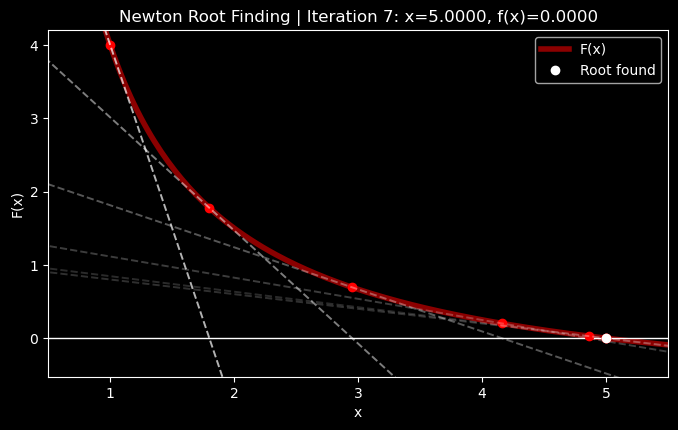

Root found: 4.999998267131661 in iterations: 7


In [36]:
# --- run newton's method --- #
initial_guess = 1 # adjust this to see the method at work! (between 0 and 10)
x1_newt, it_newt, fig = newton(F, F_numeric_derivative,
                                initial_guess, tol=1e-3,
                                max_iter=20,
                                do_plot=True)
print("Root found:", x1_newt, "in iterations:", it_newt)

### <a id='toc3_4_'></a>[3.4 scipy.optimize](#toc0_)

Solve the consumer problem now using the scipy.minimize_scalar function. Define adequate bounds.



In [37]:
from scipy import optimize

# remember that most numeric optimizers are minimizers - therefore we negate the function
# - to find the maximum of f (the minimum of -f)
objective_function = lambda x1: -value_of_choice_ces(x1,alpha,beta,I,p1,p2)

# or equivilantly:
def objective_function(x1):
    return -value_of_choice_ces(x1,alpha,beta,p1,p2,I) # my variable order is different from Jeppes!!

# remember that value_of_choice_ces returns the consumers utility given x1, prices and income.
# earlier we wrote:
# def value_of_choice_ces(x1, alpha=0.5, beta=0.5, p1=1, p2=1, I=10):
#     x2 = x2_implicit(x1,I,p1,p2)
#     util = u(x1,x2,alpha,beta)
#     return util

# run the scipy optimizer inside the bounds of possible x1 values
sol = optimize.minimize_scalar(objective_function,bounds=(0.2,I/p1))

# print the solution
u_ces = -sol.fun
x1_ces = sol.x
x2_ces = (I-x1_ces*p1)/p2
print(x1_ces,x2_ces,u_ces)

5.000003792806647 2.4999981035966763 3.535533693620822



## <a id='toc4_'></a>[4. Other Optimizers - Comparing Methods (more difficult)](#toc0_)

Solve the problem now with *SLSQP* and compare the number of iterations, function evaluations, speed, and precision with *Nelder-Mead*.


In [ ]:
import time # to compare the speed of different methods

# using SLSQP method to handle bounds #
# redefine the objective function to take alpha and beta as arguments
obj = lambda x1, alpha, beta: -value_of_choice_ces(x1,alpha,beta,p1,p2,I)
eps = 1e-6 # just a small number to avoid hitting the boundary
x0 = 2 # initial guess (try to vary this when comparing methods)

# run the optimizer
start_slsqp = time.perf_counter()
sol_slsqp = optimize.minimize(obj,x0=x0,args=(alpha, beta),bounds=[(eps, I/p1 - eps)],method="SLSQP")
end_slsqp = time.perf_counter()


start_NM = time.perf_counter()
sol_NM = optimize.minimize(obj,x0=x0,args=(alpha, beta),bounds=[(eps, I/p1 - eps)],method="Nelder-Mead")
end_NM = time.perf_counter()

import pandas as pd
df_results = (("Method", "Time (s)", "x1*", "x2*", "u*"),
              ("Bisection", "NA", x1_bis, x2_bis, u(x1_bis,x2_bis,alpha,beta)),
              ("Newton", "NA", x1_newt, x2_implicit(x1_newt,I,p1,p2), u(x1_newt,x2_implicit(x1_newt,I,p1,p2),alpha,beta)),
              ("SLSQP", end_slsqp-start_slsqp, sol_slsqp.x.item(), x2_implicit(sol_slsqp.x.item(),I,p1,p2), -sol_slsqp.fun),
              ("Nelder-Mead", end_NM-start_NM, sol_NM.x.item(), x2_implicit(sol_NM.x.item(),I,p1,p2), -sol_NM.fun)
             )
df_results = pd.DataFrame(columns=df_results[0], data=df_results[1:])
df_results

,Method,Time (s),x1*,x2*,u*
0,Bisection,NA,4.999998,2.500001,3.535534
1,Newton,NA,4.999998,2.500001,3.535534
2,SLSQP,0.003511,4.987772,2.506114,3.535523
3,Nelder-Mead,0.003435,5.000000,2.500000,3.535534


## <a id='toc5_'></a>[5. Sensitivity: Price shock](#toc0_)

- Now, assume that the price p1 doubles. Recompute (x1_star, x2_star, u_star) for each $\beta$.
- For each $\beta$, compute percentage changes relative to baseline.
- Plot two panels, where panel A contains quantities (the percentage change in x1_star and x2_star) and panel B contains the percentage change in u_star.
- Interpretation: Briefly explain how the substitution elasticity (lower beta) shapes x1_star, x2_star, and the utility.

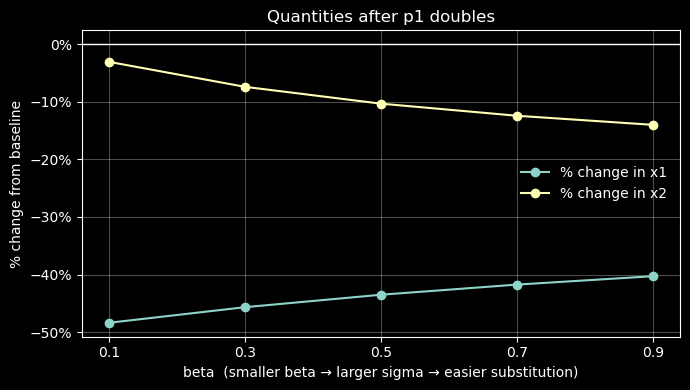

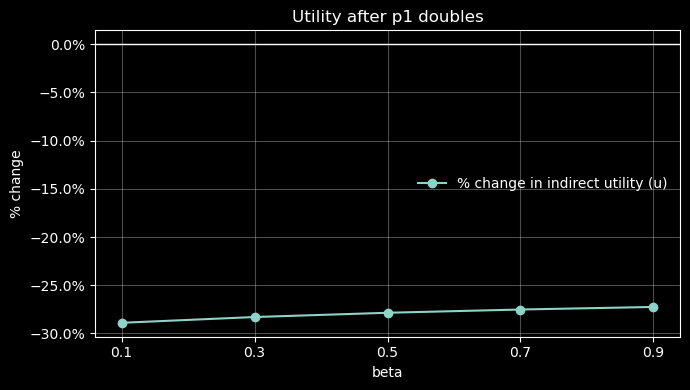

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# helper from the notebook environment for nicer DataFrame display (if available)

# ----- Economic setup & intuition -----
# CES utility: u(x1,x2) = ( alpha * x1^(-beta) + (1-alpha) * x2^(-beta) )^(-1/beta)
# Elasticity of substitution: sigma = 1 / (1 + beta)
# When sigma is high (beta small) goods are easier to substitute, so a price rise of good 1
# will cause a larger substitution away from x1 and into x2. When sigma is low (beta large),
# goods are more "complement-like" and quantities adjust less.
#
# We'll compute the Hicksian/indirect-utility-based demands using the standard CES dual formulas:
#  - budget share of good 1: s1 = alpha^sigma * p1^(1-sigma) / denom
#  - x1 = (I / p1) * s1
#  - indirect utility: u = I / C(p) with C(p) = [ alpha^sigma p1^(1-sigma) + (1-alpha)^sigma p2^(1-sigma) ]^(1/(1-sigma))

# ----- Parameters -----
alpha = 0.5     # preference weight on good 1 (symmetric here)
I = 10.0        # income
p1 = 1.0        # baseline price of good 1
p2 = 2.0        # price of good 2 (unchanged)
betas = np.array([0.1, 0.3, 0.5, 0.7, 0.9])  # the different betas to examine (0 < beta < 1)

# ----- Functions -----
def sigma_from_beta(beta):
    """Elasticity of substitution from beta"""
    return 1.0 / (1.0 + beta)

def ces_optimal_choices(I, p1, p2, alpha, beta):
    """
    Return tuple (x1, x2, u, s1, s2) for CES preferences using dual formulas.
    - x1, x2 are Marshallian demands implied by indirect utility and budget shares
    - u is the indirect utility (I / cost-of-achieving 1 unit of utility)
    """
    sigma = sigma_from_beta(beta)
    denom = (alpha ** sigma) * (p1 ** (1.0 - sigma)) + ((1.0 - alpha) ** sigma) * (p2 ** (1.0 - sigma))
    s1 = (alpha ** sigma) * (p1 ** (1.0 - sigma)) / denom
    s2 = 1.0 - s1
    x1 = (I / p1) * s1
    x2 = (I / p2) * s2
    cost = denom ** (1.0 / (1.0 - sigma))
    u = I / cost
    return x1, x2, u, s1, s2

# ----- Baseline and after shock (double p1) -----
baseline_results = np.array([ces_optimal_choices(I, p1,     p2, alpha, b) for b in betas])
shock_results    = np.array([ces_optimal_choices(I, 2.0*p1, p2, alpha, b) for b in betas])

# unpack columns: x1, x2, u
x1_base = baseline_results[:,0]
x2_base = baseline_results[:,1]
u_base  = baseline_results[:,2]

x1_shock = shock_results[:,0]
x2_shock = shock_results[:,1]
u_shock  = shock_results[:,2]

# percent change helper
pct_change = lambda new, old: 100.0 * (new - old) / old

pct_x1 = pct_change(x1_shock, x1_base)
pct_x2 = pct_change(x2_shock, x2_base)
pct_u  = pct_change(u_shock,  u_base)

# Prepare a tidy table to inspect numbers
df = pd.DataFrame({
    "beta": betas,
    "sigma": np.round([sigma_from_beta(b) for b in betas], 4),
    "x1_base": np.round(x1_base, 6),
    "x1_shock": np.round(x1_shock, 6),
    "pct_change_x1 (%)": np.round(pct_x1, 4),
    "x2_base": np.round(x2_base, 6),
    "x2_shock": np.round(x2_shock, 6),
    "pct_change_x2 (%)": np.round(pct_x2, 4),
    "u_base": np.round(u_base, 6),
    "u_shock": np.round(u_shock, 6),
    "pct_change_u (%)": np.round(pct_u, 4),
})

# ----- Plot 1: % change in quantities (x1 and x2) after p1 doubles -----
plt.figure(figsize=(7,4))
plt.plot(betas, pct_x1, marker='o', label='% change in x1')
plt.plot(betas, pct_x2, marker='o', label='% change in x2')
plt.title('Quantities after p1 doubles')
plt.xlabel('beta  (smaller beta → larger sigma → easier substitution)')
plt.ylabel('% change from baseline')
plt.axhline(0, linewidth=1)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.xticks(betas.tolist())
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ----- Plot 2: % change in (indirect) utility after p1 doubles -----
plt.figure(figsize=(7,4))
plt.plot(betas, pct_u, marker='o', label='% change in indirect utility (u)')
plt.title('Utility after p1 doubles')
plt.xlabel('beta')
plt.ylabel('% change')
plt.axhline(0, linewidth=1)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.xticks(betas.tolist())
plt.grid(True, alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


## <a id='toc6_'></a>[6. Sensitivity: Starting Values & Solver Choices](#toc0_)

- Try different starting values for Newton and `minimize`.
- Discuss your main observations and take-aways regarding number of iterations and function evaluations.
- Which one was your favorite solver in this application? Why?


In [40]:
# go crazy:
initial_guess = 2 # adjust this to see the method at work! (between 0 and 10)
x1_newt, it_newt, fig = newton(F, F_numeric_derivative, initial_guess, tol=1e-3, max_iter=20, do_plot=False)
print("Root found:", x1_newt, "in iterations:", it_newt)

x1_minimize = optimize.minimize(objective_function, x0=initial_guess, bounds=[(0.1,I/p1)])
print("Root found:", x1_minimize.x, "in iterations:", x1_minimize.nit)

Root found: 4.999998267133758 in iterations: 6
Root found: [5.14170911] in iterations: 4
